# Turning raw point time series into joint angle time series

## Imports

In [0]:
#trifecta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import h5py #reading in file

from numpy import pi

## Reading in File, Index Mapping

In [0]:
d = h5py.File('072212_163153.h5')
pos = d['positions_pred'] #pos.shape is 361000 x 2 x 32
pos[48,:,:] = pos[47,:,:] #for some weird reason, the 48th frame is weird ... can check it by plotting, so I just use prev. frame
t = np.arange(pos.shape[0])

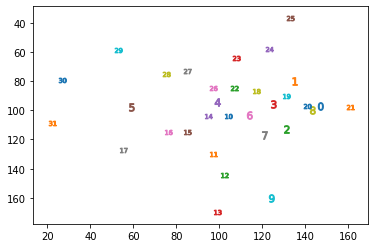

In [0]:
ff = pos[48,:,:] #first frame
ff_x = ff[0,:]
ff_y = ff[1,:]

# 0 --> tip of head, between antennae
# 1 --> left eye
# 2 --> right eye
# 3 --> neck
# 4 --> mesothoracic phragma
# 5 --> abdomen
# 6 --> Rforeleg1
# 7 --> Rforeleg2
# 8 --> Rforeleg3
# 9 --> Rforeleg4
#10 --> Rmidleg1
#11 --> 2
#12 --> 3
#13 --> 4
#14 --> Rhindleg1
#.
#.
#.
#31 --> Left wing tip
#32 --> Right wing tip

#Kanishk's code - of course accomplishes exactly what I was trying to do in a much smarter & simpler way
for i in range(ff.shape[1]):
  plt.scatter(ff_x[i], ff_y[i], marker='$'+str(i)+'$', s=60) #plots the 
plt.gca().invert_yaxis()

In [0]:
## keep rotated just in case.... but we'll just stick with the fly oriented as is 
# it also takes a while to run... so just uncomment for loops if need arises
#rotation matrix
rotation_matrix = np.array([[0, 1],
                            [1,  0]])

pos_rotated = np.empty_like(pos)
num_points = 32
#for p in range(num_points):
#  pos_rotated[:,:,p] = np.matmul(pos[:,:,p], rotation_matrix)

#plt.figure(figsize = (6,6))
ff = pos[48,:,:] #first frame
ff_x = ff[0,:]
ff_y = ff[1,:]
#for i in range(pos_rotated.shape[2]):
#  plt.scatter(pos_rotated[0,0,i], pos_rotated[0,1,i], marker = '${}$'.format(str(i)), s=100)
#plt.gca().invert_yaxis()

## User-defined functions:

getAngle --> returns angle time series of two vector time series

getJointAngles --> returns the joint angle time series from the position time series

In [0]:
def getAngle(v1, v2):
  '''
  Input: two vectors, v1 & v2, which are np arrays of size (N, 2) --> time series of (x,y) coordinates, N time points
  Output: joint angle time series, np array of shape (N, ) --> time series of the angle between the two vectors
          // might need to reshape the array with .reshape(-1,1) to fit into multi-dimensional array of all joint angles (as I did in getJointAngles) 
  '''
  #cos = ((v1*v2).sum(axis=1))/(np.linalg.norm(v1, axis=1)*np.linalg.norm(v2, axis=1)) %%timeit 28.5 ms per loop vs 32.7 ms per loop
  cos = (v1[:,0]*v2[:,0] + v1[:,1]*v2[:,1])/(np.linalg.norm(v1, axis=1)*np.linalg.norm(v2, axis=1))
  return np.arccos(cos)

def getJointAngles(pos = pos, origin_index1 = 4, origin_index2 = 3, num_angles=30):
  ''' 
  Input: position time series, np(or h5py) array of shape (N, 2, j) --> time series of (x,y) coords for j joints tracked
    (optional) origin_index1, origin_index2 --> which indices to define the origin from (default 3 & 4 for fly, corresponding to neck & thorax)
  Output: angle time series, np array of shape (N-nans, 1, num_angles) --> gets rid of all the rows with nans in the angles, and 
        (for the fly) there are num_angles=30 total angles which are computed (specified below)

  Angles 
  -------
  # 0 is the head
  # 1 & 2 are L & R eyes, respectively
  # 3 & 4 are L & R wings, respectvely
  # 5 is the abdomen
  # 6 - 9 are the R foreleg joints
  # 10 - 13 are the R midleg joints
  # 14 - 17 are the R hindleg joints
  # 18 - 21 are the L foreleg joints
  # 22 - 25 are the L midleg joints
  # 26 - 29 are the L hindleg joints
  '''

  # need to make thorax--->neck the base line
  # and every other angle relative to that
  origin = pos[:,:,origin_index1]
  neck = pos[:,:, origin_index2]

  N = pos.shape[0]
  #x is the line everything will be referenced to 
  x = neck - origin

  #initialize empty array for joint angles --> this will be shape of array returned
  joint_angles = np.empty((N, 1, num_angles))
  joints_list = set(np.arange(32)) - {3, 4, 30, 31} # get rid of the joints which we are using to define our origin line... doesn't make sense to
  # have an angle between them.... and then 30,31 out of index range --> add back after loop

  #populate joint_angles array
  for p in joints_list: #find angle between x-vector and joint vector
    joint_angles[:,:, p] = getAngle(x, pos[:,:,p] - origin).reshape(-1,1) 
  joint_angles[:,:,3] = getAngle(x, pos[:,:,30] - origin).reshape(-1,1) #make joint_angles 3 and 4 the wings
  joint_angles[:,:,4] = getAngle(x, pos[:,:,31] - origin).reshape(-1,1) #since they are definining origin
  #np.where(np.isnan(joint_angles))[0].shape ([1] or [2] as well) is 29... so 29 null vals 
  # --> np.isnan(joint_angles).sum() gives 26... presumably because of frame 48 which was giving hella problems earlier

  #remove nans
  nan_indices = np.where(np.isnan(joint_angles))[0] #rows which have a SINGLE nan in any of the cols
  notnans = [i for i in range(N) if i not in nan_indices] #the indices which aren't nans
  joint_angles = joint_angles[notnans,0,:]
  return joint_angles

## Checks

In [0]:
joint_angles = h5py.File('joint_angles.h5')['joint_angles']

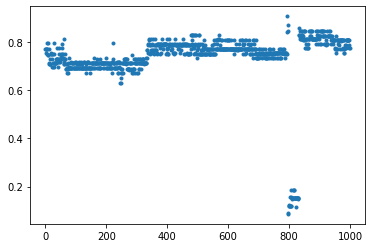

In [0]:
plt.plot(np.arange(1000), joint_angles[:1000,7],'.')

In [0]:
joint_angles = getJointAngles(pos)
print(joint_angles.shape)
#some checks: 
# 0 is the head --> angle should be pretty close to zero... the mean is 0.021, std 0.015, max is 0.109
# 1& 2 are eyes --> should be similar to each other... means are 0.4254 and 0.4367, std ~0.026, maxes 0.54 & 0.60, mins 0.2, 0.3
# 3 & 4 are wings --> closer to π, should be similar to one another.. means ~2.9, stdevs ~0.1, maxes π, mins 1.6, 0.8 ... which is fine i guess
# 5 is abdomen --> damn close to π, mean of 3.08, max of pi and min of 2.8 

# fore legs (6-9, 18-21) are closer to 0 than to π, and larger than middle/back legs 
# mid legs (10-13, 22-25) are closer to π/2 (1.57), larger than frnt smaller than back
# hind legs(14-17, 26-29) are closer to the π end, larger than front + mid

#and all the joint angles in one limb are similar to one another... don't know whether to expect this or not but i'm fairly happy

for joint in range(30):
  j = joint_angles[:,joint]
  print('{} - mean: {}, stdev: {}, max: {}, min: {}'.format(joint, j.mean(), j.std(), j.max(), j.min()))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in arccos
  if __name__ == '__main__':


(360975, 30)
0 - mean: 0.021283442291938792, stdev: 0.015358686473810735, max: 0.10975005480647863, min: 0.0
1 - mean: 0.4254134853270366, stdev: 0.026085520124982185, max: 0.5363668375540601, min: 0.18919902209996817
2 - mean: 0.4366996671735824, stdev: 0.025831442506471358, max: 0.5961991412974803, min: 0.2563476823127997
3 - mean: 2.933142685896465, stdev: 0.11524381982746652, max: 3.141592653589793, min: 1.6348368918560914
4 - mean: 2.8774140236868835, stdev: 0.09461999653961499, max: 3.141592653589793, min: 0.7853981633974483
5 - mean: 3.0886206158134915, stdev: 0.042064057433778924, max: 3.141592653589793, min: 2.815752142448454
6 - mean: 0.5032197420022837, stdev: 0.04130460069150675, max: 0.7496990507181244, min: 0.19739555984988044
7 - mean: 0.5552569856210333, stdev: 0.0946737880011199, max: 1.9825425373375298, min: 0.03702011587393292
8 - mean: 0.5270724312469045, stdev: 0.2161072480568236, max: 1.501939837493852, min: 0.0
9 - mean: 0.5882561304142998, stdev: 0.2618473909837

In [0]:
#Checking to see if joint_angles.h5 is retrievable
ja = h5py.File('joint_angles.h5')
print(list(ja.keys()))
print(ja['joint_angles'].shape) #great!

## Save file

In [0]:
with h5py.File('joint_angles.h5', 'w') as h5f:
  h5f.create_dataset('joint_angles', data = joint_angles)

## Initial Code to Create angle time series

In [0]:
# need to make thorax--->neck the base line
# and every other angle relative to that

origin = pos[:, :, 4]
neck   = pos[:, :, 3]
x = neck - origin

joint_angles = np.empty((pos.shape[0], 1, 30))
joints_list = set(np.arange(32)) - {3, 4, 30, 31} # get rid of the joints which we are using to define our origin line... doesn't make sense to
# have an anglee between them.... and then 30,31 out of index range --> add back after loop

for p in joints_list: #find angle between x-vector and joint vector
  joint_angles[:,:, p] = getAngle(x, pos[:,:,p] - origin).reshape(-1,1) 
joint_angles[:,:,3] = getAngle(x, pos[:,:,30] - origin).reshape(-1,1) #make joint_angles 3 and 4 the wings
joint_angles[:,:,4] = getAngle(x, pos[:,:,31] - origin).reshape(-1,1) #since they are definining origin
#np.where(np.isnan(joint_angles))[0].shape ([1] or [2] as well) is 29... so 29 null vals 
# --> np.isnan(joint_angles).sum() gives 26... presumably because of frame 48 which was giving hella problems earlier

#remove nans
nan_indices = np.where(np.isnan(joint_angles))[0]
notnans = [i for i in range(pos.shape[0]) if i not in nan_indices]
#nans at 68386, 75266, 85916, ... 297161, 297161, 299093
#joint_angles(np.where(np.isnan(joint_angles))[0], :, :)
joint_angles = joint_angles[notnans]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in arccos
  after removing the cwd from sys.path.
